In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM

Языковая модель (LLM) - это статистическая модель, которая используется для предсказания вероятности последовательности слов или фраз в рамках определенного языка. Она используется в различных областях обработки естественного языка, таких как машинный перевод, распознавание речи, исправление ошибок и другие. Языковая модель помогает компьютеру понять и генерировать естественный язык, учитывая контекст и вероятность последовательности слов.

При работе LLM используют разные подходы к генерации текста, самый стандартный это autoregressive sampling, однако существуют и другие более продвинутые методы, которые помогают ускорить работу модели, в данной работе будет реализован стандартный метод сэмплировния autoregressive sampling, а также более умный метод speculative sampling. Будет проведен сравнительный анализ эффективности двух методов

### Autoregressive Sampling

Ниже представлен стандартный алгоритм сэмплирования языковых моделей, каждый следующий токен последовательности генерируется с учетом предыдущих.

<img width="654" alt="image" src="https://github.com/markovka17/dla/assets/20357655/db624e40-d4f0-4e36-88e7-b58a6c646738">

Реализуем этот алгоритм для модели GPT-NEO-1.3B, на вход дадим модели предложение The quick brown fox jumps, посмотрим что дальше сгенерирует модель для этого предложения

In [4]:
# Ensure that your device is set correctly (GPU or CPU)
device = 'cuda'

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
model = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B', torch_dtype=torch.float16).to(device)
model.eval()  # Set the model to evaluation mode

# Prepare a text prompt
text_prompt = ["The quick brown fox jumps"]
inputs = tokenizer(text_prompt, return_tensors='pt').to(device)  # Tokenize the text prompt and convert to tensor

max_length = 100  # Maximum length of the generated text
temperature = 1.0  # Sampling temperature, higher values mean more randomness

with torch.no_grad():  # Disable gradient calculation for inference
    output_sequence = inputs['input_ids']
    for _ in range(max_length - inputs['input_ids'].size(1)):
        # Predict the next token
        logits = model(output_sequence).logits[:, -1, :]
        
        # Apply temperature
        logits = logits / temperature
        
        # Sample the next token from the probability distribution
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        # Append the predicted token to the output sequence
        output_sequence = torch.cat([output_sequence, next_token], dim=1)

        # Check if the end-of-sequence token (EOS) was generated
        if next_token.item() == tokenizer.eos_token_id:
            break

# Decode and print the generated text
generated_text = tokenizer.decode(output_sequence.squeeze(), skip_special_tokens=True)
print("Generated text:\n", generated_text)


tokenizer_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Generated text:
 The quick brown fox jumps over the lazy dog" "♪ Ooh, ooh, ooh" "♪ A little bit ooh, a little bit frack, a little bit frack ♪" "♪ A little bit ooh, a little bit frack, a little bit frack." "♪ ♪" "Why don't you humans inside?" "♪ Hey, I cannae see it laff ya, take my advice" "


Получили сгенерированный текст, видим, что сначала модель уловила смысл предложения и корректно его продолжила, а далее уже начала уходить из контекста и придумывать свое продолжение

Возьмем модель побольше, а именно GPTJ-6B, у которой 6 миллиардов обучаемых параметров

In [5]:
large_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", torch_dtype=torch.float16).to(device)

config.json:   0%|          | 0.00/930 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/24.2G [00:00<?, ?B/s]

/home/aushevis/speech_course/speech_course/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Посмотрим на слои этой модель

In [6]:
large_model.eval()

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

Прошлый подход для сэмплирования работает, но существуют методы более быстрой генерации, одним из таких является speculative sampling, предложенный в статье https://arxiv.org/pdf/2302.01318

Идея speculative sampling заключается в следующем, мы берем две языковых модели:

Маленькую быструю драфт модель (например, EleutherAI/gpt-neo-1.3B, у которой только 1.3 миллиарда параметров)
И большую, медленную таргет модель (в нашем случае это EleutherAI/gpt-j-6B), которой мы хотим генерировать ответ

Идея заключается в том, что драфт модель предполагает, что результатом генерации таргет модели будут какие-то токены, в то время как целевая модель определяет, сколько из этих токенов мы должны принять. Вот краткое описание алгоритма:

Драфт модель декодирует токены обычным способом авторегрессии.
Мы получаем вероятностные выходные данные таргет и драфт моделей для новой предсказанной последовательности.
Мы сравниваем вероятности таргет и драфт моделей, чтобы определить, сколько токенов мы хотим сохранить, основываясь на некоторых критериях отклонения. Если токен отклонен, мы проводим повторную выборку, используя комбинацию двух распределений, и больше не принимаем токены.
Если все токены приняты, мы можем выбрать дополнительный конечный токен из выходных данных вероятности таргет модели.

Благодаря такому подходу мы меньше используем большую таргет модель, а большинство вычислений производит маленькая модель, благодаря чему и происходит выигрыш по времени

<img width="635" alt="image" src="https://github.com/markovka17/dla/assets/20357655/3954894d-8735-4f92-a835-d04eac74f190">

Реализуем speculative sampling

In [38]:
@torch.no_grad()
def speculative_sampling(x, draft_model, target_model, N, K, use_cache=True, debug=True):
    # NOTE: paper indexes arrays starting from 1, python indexes from 0, so
    # we have to add an extra -1 term when indexing using n, T, or t
    with torch.no_grad():
        n = len(x)
        one = torch.tensor(1)
        output_sequence = x['input_ids']
        generated_tokens = 0
        accepted_tokens = 0
        while output_sequence.shape[1] < N:
            # Step 1: auto-regressive decode K tokens from draft model and get final p
            # logits_draft = torch.rand(1)
            res = draft_model.generate(output_sequence, 
                                       max_new_tokens=K, 
                                       output_scores=True, 
                                       return_dict_in_generate=True, 
                                       do_sample=True,
                                       pad_token_id=tokenizer.eos_token_id, use_cache=use_cache)
            logits_draft = torch.concat(res.scores).unsqueeze(0)
            output_sequence = res.sequences
            generated_tokens += logits_draft.shape[1]
            
            # Step 2: target model forward passes on x_draft
            seq_len = output_sequence.shape[1]
            draft_len = logits_draft.shape[1]
            logits_target = target_model(output_sequence).logits[:, seq_len - draft_len - 1:, :]

            # Step 3: append draft tokens based on rejection criterion and resample
            # a token on rejection
            all_accepted = True
            probs_draft = torch.nn.functional.softmax(logits_draft[:, :, :], dim=-1)
            probs_target = torch.nn.functional.softmax(logits_target[:, :, :probs_draft.shape[2]], dim=-1)
            for t in range(probs_draft.shape[1]):
                r = torch.rand(output_sequence.shape[0], device=device)
                predicted_token = output_sequence[:, seq_len - draft_len + t - 1]

                if torch.all(r <= torch.min(one, probs_target[:, t , predicted_token] / probs_draft[:, t, predicted_token])):
                    accepted_tokens += 1
                    continue
                else:
                    all_accepted = False
                    probabilities = torch.nn.functional.relu(probs_target[:, t,:] - probs_draft[:, t, :])
                    probabilities = probabilities / probabilities.sum()
                    next_token = torch.multinomial(probabilities, num_samples=1)
                    output_sequence = output_sequence[:, :seq_len - draft_len + t]
                    output_sequence = torch.cat([output_sequence, next_token], dim=1)
                    break
            
            # Step 4: if all draft tokens were accepted, sample a final token
            if all_accepted:
                # print("ALL accepted")
                probabilities = torch.nn.functional.softmax(logits_target[:, -1 ,:], dim=-1)
                next_token = torch.multinomial(probs_target[:, -1, :], num_samples=1)
                output_sequence = torch.cat([output_sequence, next_token], dim=1)
                
            assert n == len(x), f"{n} {len(x)}"
        acceptance_rate = accepted_tokens / generated_tokens
    return output_sequence, acceptance_rate

Протестируем работу алгоритма

In [45]:
output_sequence, acceptance_rate = speculative_sampling(inputs, model, large_model, 100, 3)
generated_text = tokenizer.decode(output_sequence.squeeze(), skip_special_tokens=True)
print('Acceptence rate: ', acceptance_rate)
print("Generated text:\n", generated_text)

Acceptence rate:  0.9333333333333333
Generated text:
 The quick brown fox jumps over the lazy dog….

Tag Archive

The quick brown fox jumps over the lazy dog in the morning, and you never notice it’s missing. “D” is for diabetic shock.

Nothing is more annoying and embarrassing than having to admit that you have a disease. I went to a medical conference a few weeks ago and was surprised that I came back with a.1% chance that I have Diabetic Shock.

I


Сравним эффективность стандартного подхода и speculative sampling, для этого будем использовать torch.profiler для оценки производительности CPU и GPU 

In [50]:
from typing import Optional, Callable, Dict, Sequence

from dataclasses import dataclass, field
from tqdm import trange
import time

from matplotlib import pyplot as plt

import torch.nn.functional as F
from torch import nn
from torch.amp import autocast
import torch.backends.xnnpack
from torch.profiler import profile, schedule, ProfilerActivity

In [51]:
@dataclass
class ProfilerConfig:
    scheduler: Optional[Callable[[int], int]] = field(default=None, metadata={"omegaconf_ignore": True})
    num_steps: int = field(init=False)
    amp: bool = False

    def __post_init__(self):
        if self.scheduler is None:
            self.scheduler = {"skip_first": 0, "wait": 1, "warmup": 1, "active": 3, "repeat": 0}

        self.num_steps = sum([v for k, v in self.scheduler.items() if k != "repeat"])
        self.scheduler = schedule(**self.scheduler)

@torch.inference_mode()
def profile_model(model: nn.Module, input: Dict[str, torch.Tensor], config: ProfilerConfig):
    training_state = model.training
    model.eval()

    with autocast(dtype=torch.float16, device_type="cuda", enabled=config.amp), profile(
        activities=[ProfilerActivity.CUDA ],
        schedule=config.scheduler
    ) as p:
        for _ in range(config.num_steps):
            _ = model(**input)
            p.step()

    model.train(training_state)
    return p

In [52]:
class DefaultModel(nn.Module):
    def __init__(self, model, max_length):
        super().__init__()
        self.model = model
        self.max_length = max_length

    def forward(self, text_prompt):
        with torch.no_grad():  # Disable gradient calculation for inference
            input = tokenizer(text_prompt, return_tensors='pt').to(device)
            output_sequence = input['input_ids']
            for _ in range(self.max_length - input['input_ids'].size(1)):
                # Predict the next token
                logits = model(output_sequence).logits[:, -1, :]
                
                # Sample the next token from the probability distribution
                probabilities = torch.nn.functional.softmax(logits, dim=-1)
                next_token = torch.multinomial(probabilities, num_samples=1)
                
                # Append the predicted token to the output sequence
                output_sequence = torch.cat([output_sequence, next_token], dim=1)

                # Check if the end-of-sequence token (EOS) was generated
                # if next_token.item() == tokenizer.eos_token_id:
                #     break
            return output_sequence
        
class SpsModel(nn.Module):
    def __init__(self, draft_model, target_model, max_length):
        super().__init__()
        self.draft_model = draft_model
        self.target_model = target_model
        self.max_length = max_length

    def forward(self, text_prompt, K):
        return speculative_sampling(text_prompt, self.draft_model, self.target_model, self.max_length, K)

Сначала посмотрим сколько будет генерироваться текст длины 512 для стандартного метода

In [49]:
p = profile_model(DefaultModel(large_model, 512), {'text_prompt': text_prompt}, ProfilerConfig(amp=False))
print(p.key_averages())

STAGE:2024-05-03 09:54:55 1597137:1597137 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-05-03 09:55:52 1597137:1597137 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-05-03 09:55:54 1597137:1597137 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        cudaMemcpyAsync        16.13%        3.629s        16.13%        3.629s      91.753us       0.000us         0.00%       0.000us       0.000us         39552  
                       Memcpy HtoD (Pageable -> Device)         0.00%       0.000us         0.00%       0.000us       0.000us      33.608ms         0.08%      33.608ms       0.921us         36510  
         

Так как все вычисления производились на GPU, то нас интересует именно последняя строчка выхода профайлера, у обычного метода заняло 42 секунды на работу

Теперь попробуем speculative sampling для K=16

In [53]:
p = profile_model(SpsModel(model, large_model, 512), {'text_prompt': inputs, 'K':16}, ProfilerConfig(amp=False))
print(p.key_averages())

STAGE:2024-05-03 10:00:06 1597137:1597137 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-05-03 10:01:21 1597137:1597137 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-05-03 10:01:24 1597137:1597137 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        60.17%       14.365s        60.17%       14.365s       7.923us       0.000us         0.00%       0.000us       0.000us       1813069  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us       8.035ms         0.03%       8.035ms       2.013us          3991  
void at::

Получили большой прирост в скорости, более чем на 10 секунд, получили ускорение на 25%

Теперь возьмем K=32

In [54]:
p = profile_model(SpsModel(model, large_model, 512), {'text_prompt': inputs, 'K':32}, ProfilerConfig(amp=False))
print(p.key_averages())

STAGE:2024-05-03 10:06:58 1597137:1597137 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-05-03 10:08:39 1597137:1597137 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-05-03 10:08:42 1597137:1597137 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        69.14%       19.911s        69.14%       19.911s       7.819us       0.000us         0.00%       0.000us       0.000us       2546654  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us      11.938ms         0.03%      11.938ms       2.007us          5949  
void at::

Ускорение менее заметное, но это было ожидаемо, потому что при больших K acceptence rate маленькой модели мал, что заставляет большую модель делать больше итераций, соответственно замедляя работу алгоритма

Возьмем K=9

In [61]:
p = profile_model(SpsModel(model, large_model, 512), {'text_prompt': inputs, 'K':9}, ProfilerConfig(amp=False))
print(p.key_averages())

STAGE:2024-05-03 10:42:11 1597137:1597137 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-05-03 10:43:26 1597137:1597137 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-05-03 10:43:28 1597137:1597137 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel        50.99%       13.576s        50.99%       13.576s       7.971us       0.000us         0.00%       0.000us       0.000us       1703023  
void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us       7.095ms         0.02%       7.095ms       2.039us          3479  
void at::

Получили результат лучше, чем при K=32, но хуже, чем при K=16

Изобразим зависимость acceptence_rate от K

In [55]:
K = [8, 16, 32, 64, 128]
acceptence_rates = []
for k in K:
    res, rate = speculative_sampling(inputs, model, large_model, 1024, k)
    acceptence_rates.append(rate)

In [56]:
for ind, k in enumerate(K):
    print(f'acceptence rate for K={k}: ', acceptence_rates[ind])

acceptence rate for K=8:  0.895
acceptence rate for K=16:  0.8473214285714286
acceptence rate for K=32:  0.6360677083333334
acceptence rate for K=64:  0.4459821428571429
acceptence rate for K=128:  0.338125


Text(0, 0.5, 'Acceptence rate')

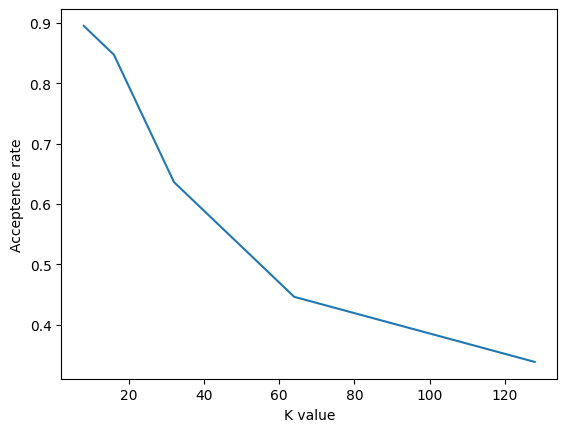

In [57]:
plt.plot(K, acceptence_rates)
plt.xlabel("K value")
plt.ylabel("Acceptence rate")

видим, что с ростом K acceptence rate убывает, что очень важно для алгоритма

Вывод:

В работе я сравнил два метода сэмплирования токенов для языковых моделей, как оказалось, speculative sampling позволяет получить значительный прирост в эффективности, и поэтому может использоваться на практике. Однако, стоит отметить, что speculative sampling требует больше памяти GPU, чем авторегрессия, что приносит свои неудобства в работе